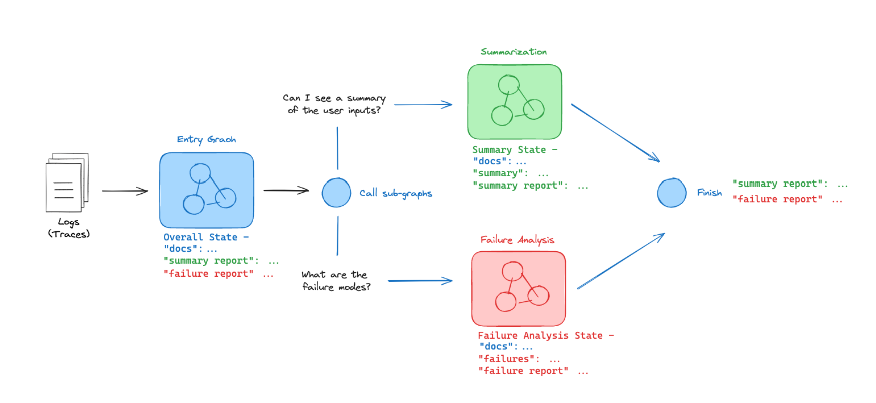

In [71]:
from typing import Optional, Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display



# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    answer: str
    grade: Optional[int]
    feedback: Optional[str]


# Define custom reducer (see more on this in the "Custom reducer" section below)
def add_logs(left: list[Logs], right: list[Logs]) -> list[Logs]:
    if not left:
        left = []

    if not right:
        right = []

    logs = left.copy()
    left_id_to_idx = {log["id"]: idx for idx, log in enumerate(logs)}
    # update if the new logs are already in the state, otherwise append
    for log in right:
        idx = left_id_to_idx.get(log["id"])
        if idx is not None:
            logs[idx] = log
        else:
            logs.append(log)
    return logs

# Summarization subgraph

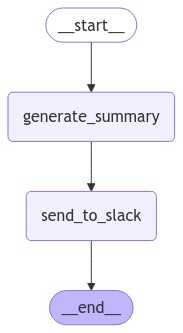

In [72]:

class QuestionSummarizationState(TypedDict):
    # keys that are shared with the parent graph (EntryGraphState)
    summary_report: str

    extra_input:str 
    logs: Annotated[list[Logs], add_logs]
    # subgraph keys
    summary: str
    


def generate_summary(state: QuestionSummarizationState):
    print("Summarization graph", state)
    docs = state["logs"]
    # NOTE: you can implement custom summarization logic here
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    state["summary"] = summary
    return state


def send_to_slack(state: QuestionSummarizationState):
    summary = state["summary"]
    # NOTE: you can implement custom logic here, for example sending the summary generated in the previous step to Slack
    summary = state["extra_input"] + "----" + summary
    state["summary_report"] = summary
    return state


qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

qs_builder_graph = qs_builder.compile()
display(Image(qs_builder_graph.get_graph(xray=1).draw_mermaid_png()))


# Failure Analysis Subgraph

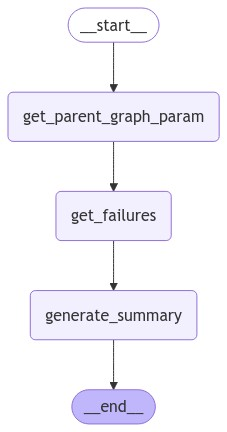

In [73]:

class FailureAnalysisState(TypedDict):
    # keys shared with the parent graph (EntryGraphState)
    extra_input:str
    f_extra_input:str
    logs: Annotated[list[Logs], add_logs]
    
    
    failure_report: str
    # subgraph key
    failures: list[Logs]

def get_parent_graph_param(state:FailureAnalysisState):
    print("get_parent_graph_param", state)
    state["f_extra_input"] = state["extra_input"]
    state["extra_input"] = ""
    return state


def get_failures(state: FailureAnalysisState):
    print("Failure graph", state)
    failures = [log for log in state["logs"] if log["grade"] == 0]
    state["failures"] = failures
    return state


def generate_summary(state: FailureAnalysisState):
    failures = state["failures"]
    # NOTE: you can implement custom summarization logic here
    failure_ids = [log["id"] for log in failures]
    fa_summary = f"Poor quality of retrieval for document IDs: {', '.join(failure_ids)}"
    # fa_summary = state["extra_input"] + "----" + fa_summary
    state["fa_summary"] = fa_summary
    return state


fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_parent_graph_param",get_parent_graph_param)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.add_edge(START, "get_parent_graph_param")
fa_builder.add_edge("get_parent_graph_param", "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)


fa_builder_graph = fa_builder.compile()
display(Image(fa_builder_graph.get_graph(xray=1).draw_mermaid_png()))

# Entry Graph

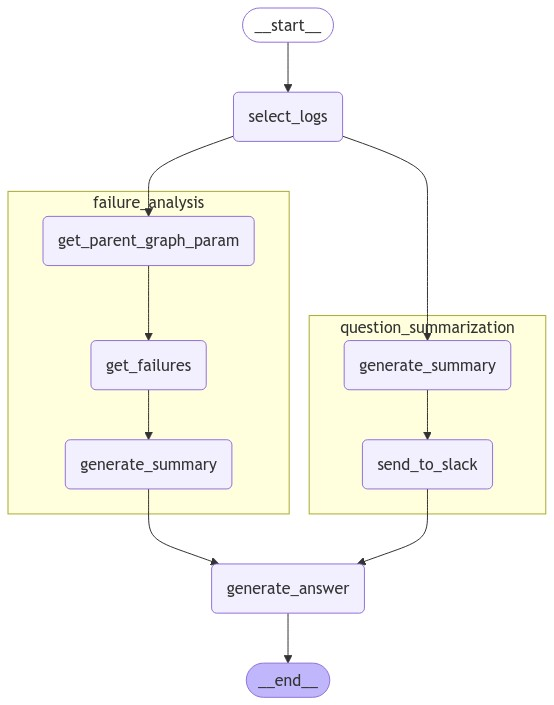

In [74]:

class EntryGraphState(TypedDict):
    extra_input:str ### Experiment- try to use is subgraph
    logs: Annotated[list[Logs], add_logs]  # This will be used in subgraphs
    raw_logs: Annotated[list[Logs], add_logs]
    
    failure_report: str  # This will be generated in the FA subgraph
    summary_report: str  # This will be generated in the QS subgraph
    answer:str


def select_logs(state):
    state["logs"] = [log for log in state["raw_logs"] if "grade" in log]
    print("EntryGraphState",state)
    return state

def generate_answer(state):
    failure_report = state["failure_report"]
    summary_report = state["summary_report"]
    state["answer"] = failure_report + "--" + summary_report
    return state
    
    


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("select_logs", select_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
entry_builder.add_node("generate_answer",generate_answer)

entry_builder.add_edge(START, "select_logs")
entry_builder.add_edge("select_logs", "failure_analysis")
entry_builder.add_edge("select_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", "generate_answer")
entry_builder.add_edge("question_summarization", "generate_answer")
entry_builder.add_edge("generate_answer",END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [75]:
# Dummy logs
dummy_logs = [
    Logs(
        id="1",
        question="How can I import ChatOllama?",
        grade=1,
        answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
    ),
    Logs(
        id="2",
        question="How can I use Chroma vector store?",
        answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
        grade=0,
        feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
    ),
    Logs(
        id="3",
        question="How do I create react agent in langgraph?",
        answer="from langgraph.prebuilt import create_react_agent",
    ),
]

graph.invoke({"raw_logs": dummy_logs,"extra_input":"testing input"}, debug=False)


EntryGraphState {'extra_input': 'testing input', 'logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'grade': 1, 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}], 'raw_logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'grade': 1, 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}, {'id': '3', 'question': 'How d

InvalidUpdateError: At key 'extra_input': Can receive only one value per step. Use an Annotated key to handle multiple values.